# 2. Le + AQC

Pipeline: Isabel's code, tranform to quantum cirucit, mapping to qubits

1. Construct Hamiltonian

In [1]:
from ropt_aqc.initialise_hamiltonians import get_hamiltonian_terms, build_matrix_from_terms

num_sites = 6
degree = 2
n_repetitions = 5
n_id_layers = 0

In [2]:
# Ising-1d
J=1.
t = 2.0
g=0.75
h=0.6
system = 'ising-1d'

terms, params = get_hamiltonian_terms(num_qubits=num_sites, system=system, J=J, g=g, h=h)

J = params['J']
h = params['h']
g = params['g']

In [3]:
# # Custom
# t = 2.0
# system = 'custom'
# terms = [
#     (0, 1, 'X', 'X', 0.5),
#     (1, 2, 'Y', 'Y', 0.3),
#     (2, 3, 'Z', 'Z', 0.8)
# ]
# h_terms, params = get_hamiltonian_terms(num_qubits=4, system='custom', pauli_terms=terms)
# H = build_matrix_from_terms(h_terms, num_qubits=4)
# print('params: ', params)
# print('H: ', H)


In [4]:
# import jax.numpy as jnp
# import jax

# t = 2.0
# num_sites = 10
# system = 'custom'
# key = jax.random.PRNGKey(0)
# key, subkey = jax.random.split(key)
# Js = jax.random.uniform(subkey, shape=(num_sites - 1,), minval=0.5, maxval=1.5)

# # Generate edge list for 1D chain
# elist = [(i - 1, i) for i in range(1, num_sites)]
# even_edges = elist[::2]
# odd_edges = elist[1::2]

# # Build pauli_terms for XXZ
# pauli_terms = []
# for i, (q1, q2) in enumerate(even_edges + odd_edges):
#     J = Js[i]
#     pauli_terms += [
#         (q1, q2, 'X', 'X', J / 2),
#         (q1, q2, 'Y', 'Y', J / 2),
#         (q1, q2, 'Z', 'Z', J)
#     ]

# terms, _ = get_hamiltonian_terms(num_qubits=num_sites, system='custom', pauli_terms=pauli_terms)
# H = build_matrix_from_terms(terms, num_qubits=num_sites)
# print(H)

# # Observable
# observable_terms = [(num_sites // 2 - 1, num_sites // 2, 'Z', 'Z', 1.0)]
# obs_terms, _ = get_hamiltonian_terms(num_qubits=num_sites, system='custom', pauli_terms=observable_terms)
# Obs = build_matrix_from_terms(obs_terms, num_qubits=num_sites)

In [5]:
# import numpy as np
# from ropt_aqc.spin_systems import get_brickwall_trotter_gates_custom
# gates = get_brickwall_trotter_gates_custom(t=t, n_sites=num_sites, n_repetitions=n_repetitions, degree=degree, hamiltonian_terms=params, use_TN=False)
# print(gates)
# print(np.array(gates).shape)  # Should be (N, 4, 4) for 2-qubit gates

In [6]:
# # Matrices for qc
# from ropt_aqc.brickwall_circuit import get_initial_gates

# gates_initial = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=False, hamiltonian_terms=params)
# print(np.array(gates_initial).shape) 

2. Get Trotterised brickwall gates

In [7]:
from ropt_aqc.spin_systems import get_brickwall_trotter_gates_spin_chain

gates_ising = get_brickwall_trotter_gates_spin_chain(t=t, n_sites=num_sites, n_repetitions=n_repetitions, hamiltonian=system, degree=degree, J=J, g=g, h=h)

In [8]:
import numpy as np
print(np.array(gates_ising).shape)  # Should be (N, 4, 4) for 2-qubit gates

(28, 4, 4)


In [9]:
# Matrices for qc
from ropt_aqc.brickwall_circuit import get_initial_gates

gates_initial = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=False, J=-J, g=g, h=h)
print(np.array(gates_initial).shape) 

(28, 4, 4)


3. View Initial Circuit

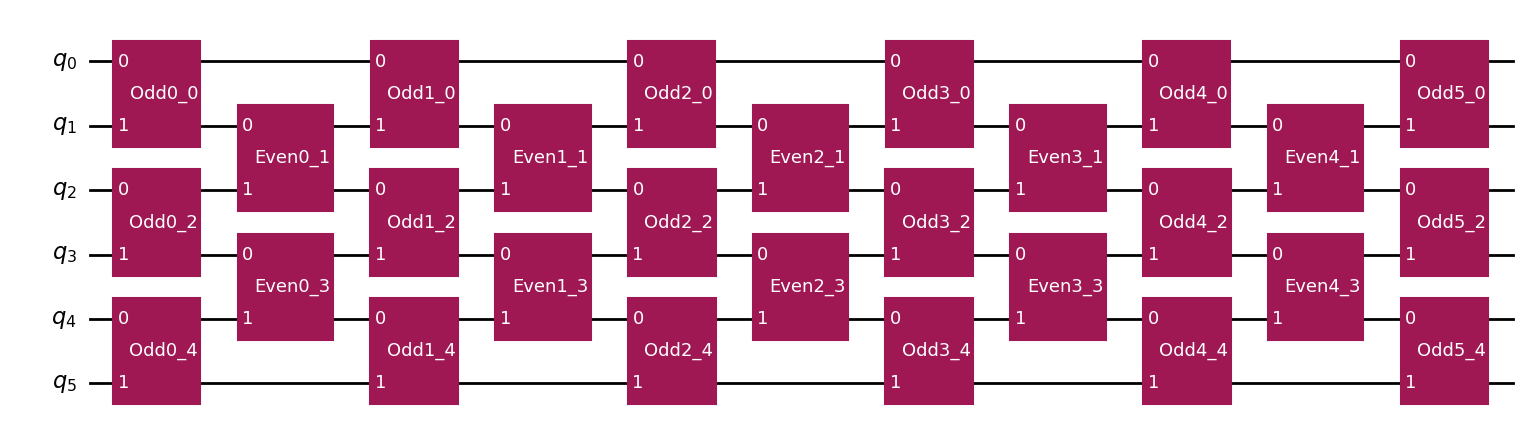

In [10]:
from ropt_aqc.circuit_building import transform_to_bw_qc_unitarygate

qc_initial = transform_to_bw_qc_unitarygate(num_sites=num_sites, system = system, gates=gates_initial, pauli_terms=terms)
qc_initial.draw('mpl')

In [11]:
# Custom
# gates = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=True, hamiltonian_terms=params)
# print(np.array(gates).shape)  # Should be (N, 4, 4) for 2-qubit gates

In [12]:
# TN for optimisation
from ropt_aqc.brickwall_circuit import get_initial_gates
gates = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=True, J=J, g=g, h=h)
print(np.array(gates).shape)  # Should be (N, 4, 4) for 2-qubit gates


(28, 2, 2, 2, 2)


Load Reference unitary - to be modified if n_repetitions changes

In [13]:
from ropt_aqc.save_model import load_reference
import os
import yaml
repo_root = "/Users/aag/Documents/ropt-aqc/"
config_file = os.path.join(repo_root, "run", system, "configs", "config.yml") 

with open(config_file, "r") as f:
    config = yaml.safe_load(f)

config['ref_nbr'] = n_repetitions

config['reference_dir'] = f'/Users/aag/Documents/ropt-aqc/run/{system}/reference'

U_ref, t, _, _, _, _, _, _, _, J, g, h= load_reference(config['reference_dir'], config['n_sites'], config['ref_nbr'])

QR sweep on U_ref

In [14]:
from ropt_aqc.tn_helpers import left_to_right_QR_sweep

U_ref = left_to_right_QR_sweep(U_ref, get_norm=False, normalize=config['normalize_reference'])
print("U_ref shape:", [m.shape for m in U_ref])

U_ref shape: [(1, 2, 2, 4), (4, 2, 2, 16), (16, 2, 2, 23), (23, 2, 2, 16), (16, 2, 2, 4), (4, 2, 2, 1)]


4. Optimisation of Frobenius norm

Start Riemannian ADAM optimization ...
	 0 	Current cost:  0.0030317537901956015
	 1 	Current cost:  0.066380964956813
	 2 	Current cost:  0.007521413000877386
	 3 	Current cost:  0.030277942637917832
	 4 	Current cost:  0.027450479147804296
	 5 	Current cost:  0.009536551627832734
	 6 	Current cost:  0.009616071907697199
	 7 	Current cost:  0.017167670611123675
	 8 	Current cost:  0.014557738948043575
	 9 	Current cost:  0.0073937198220181966
	 10 	Current cost:  0.005618010433094289
	 11 	Current cost:  0.008019293284445839
	 12 	Current cost:  0.00829363472762723
	 13 	Current cost:  0.0060708033000833606
	 14 	Current cost:  0.0046660585257973786
	 15 	Current cost:  0.004796308578608688
	 16 	Current cost:  0.004622946109552606
	 17 	Current cost:  0.003722553392317307
	 18 	Current cost:  0.0033528053843194794
	 19 	Current cost:  0.003595677183844792
	 20 	Current cost:  0.003276343959176753
	 21 	Current cost:  0.002262712337737005
	 22 	Current cost:  0.0017962463011189644
	 2

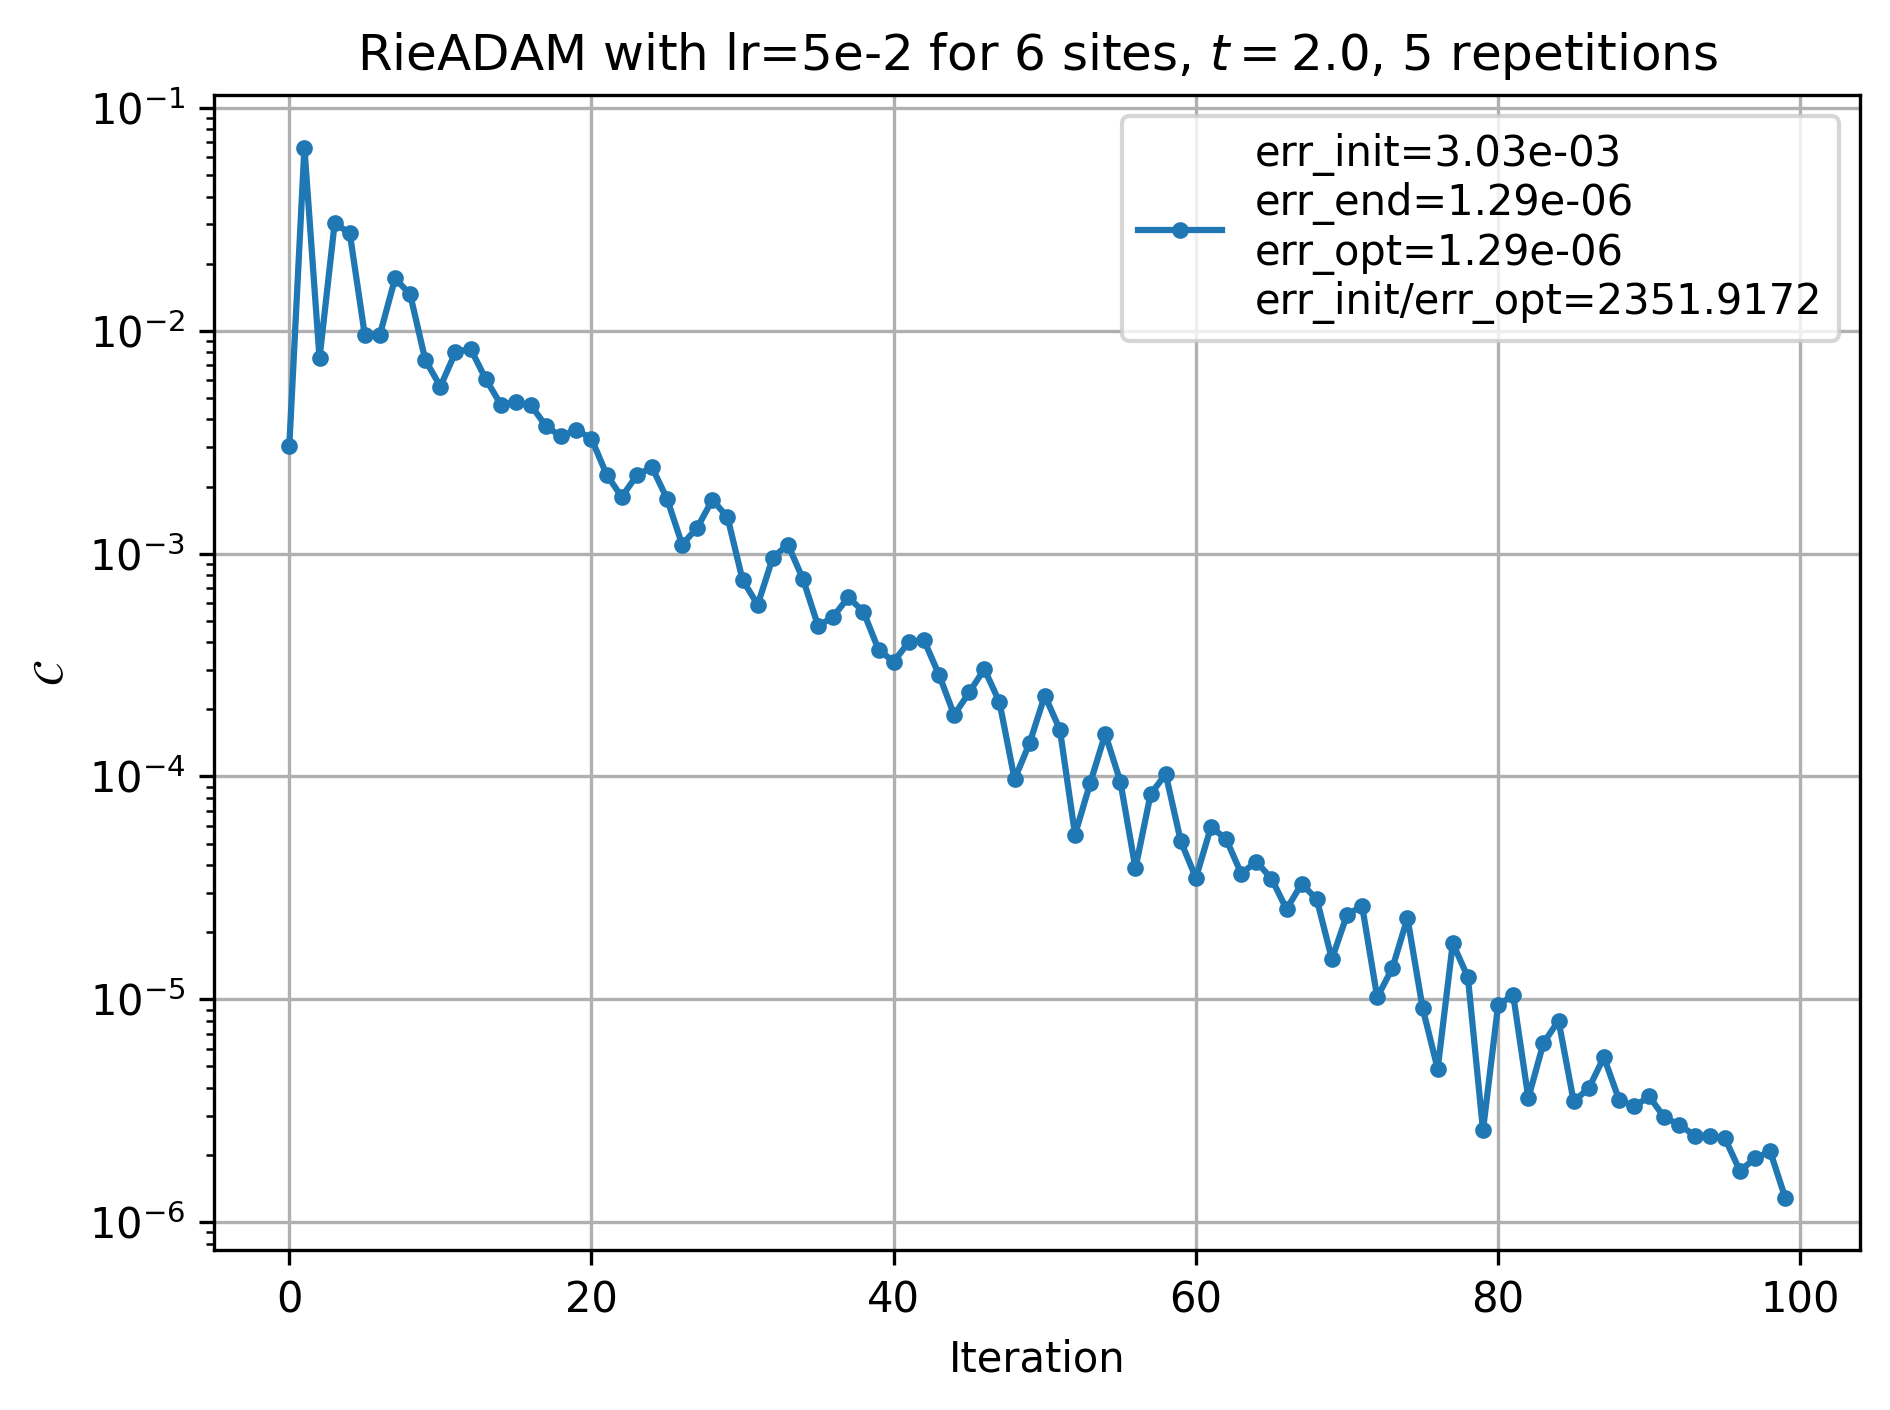

In [15]:
from ropt_aqc.brickwall_opt import optimize_swap_network_circuit_RieADAM
import pdb

gates_optimised, err_iter = optimize_swap_network_circuit_RieADAM(config, U_ref, gates)

Visualise optimised cirucit

In [16]:
gates_optimised = gates_optimised.reshape((len(gates_optimised), 4, 4))

In [17]:
np.allclose(gates_optimised, gates_initial)  # Should be False

False

In [18]:
from ropt_aqc.initialise_hamiltonians import hamiltonian_to_sparse_pauli_op
H_pauli = hamiltonian_to_sparse_pauli_op(terms, num_qubits=num_sites)
print(H_pauli)

SparsePauliOp(['ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ', 'ZIIIII', 'XIIIII', 'IZIIII', 'IXIIII', 'IIZIII', 'IIXIII', 'IIIZII', 'IIIXII', 'IIIIZI', 'IIIIXI', 'IIIIIZ', 'IIIIIX'],
              coeffs=[1.        +0.j, 1.        +0.j, 1.        +0.j, 1.        +0.j,
 1.        +0.j, 0.60000002+0.j, 0.75      +0.j, 0.60000002+0.j,
 0.75      +0.j, 0.60000002+0.j, 0.75      +0.j, 0.60000002+0.j,
 0.75      +0.j, 0.60000002+0.j, 0.75      +0.j, 0.60000002+0.j,
 0.75      +0.j])


In [19]:
from ropt_aqc.initialise_hamiltonians import hamiltonian_to_sparse_observable

H_sparse = hamiltonian_to_sparse_observable(terms, num_qubits=num_sites)
print(H_sparse)

<SparseObservable with 17 terms on 6 qubits: (1+0j)(Z_5 Z_4) + (1+0j)(Z_4 Z_3) + (1+0j)(Z_3 Z_2) + (1+0j)(Z_2 Z_1) + (1+0j)(Z_1 Z_0) + (0.6000000238418579+0j)(Z_5) + (0.75+0j)(X_5) + (0.6000000238418579+0j)(Z_4) + (0.75+0j)(X_4) + (0.6000000238418579+0j)(Z_3) + (0.75+0j)(X_3) + (0.6000000238418579+0j)(Z_2) + (0.75+0j)(X_2) + (0.6000000238418579+0j)(Z_1) + (0.75+0j)(X_1) + (0.6000000238418579+0j)(Z_0) + (0.75+0j)(X_0)>


In [20]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp

matrix_sp_op = SparsePauliOp.from_sparse_observable(H_sparse).to_matrix()
matrix_H_pauli = H_pauli.to_matrix()

print(np.allclose(matrix_sp_op, matrix_H_pauli))


True


In [21]:
# one option for reference cirucit
# initial time evolution
# construct initial state
from qiskit import QuantumCircuit

initial_state = QuantumCircuit(num_sites)
for i in range(num_sites):
    if i % 2:
        initial_state.x(i)

from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

# Generate the AQC target circuit (initial segment)
aqc_evolution_time = 0.2
aqc_target_num_trotter_steps = 32

aqc_target_circuit = initial_state.copy()
aqc_target_circuit.compose(
    generate_time_evolution_circuit(
        H_sparse,
        synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

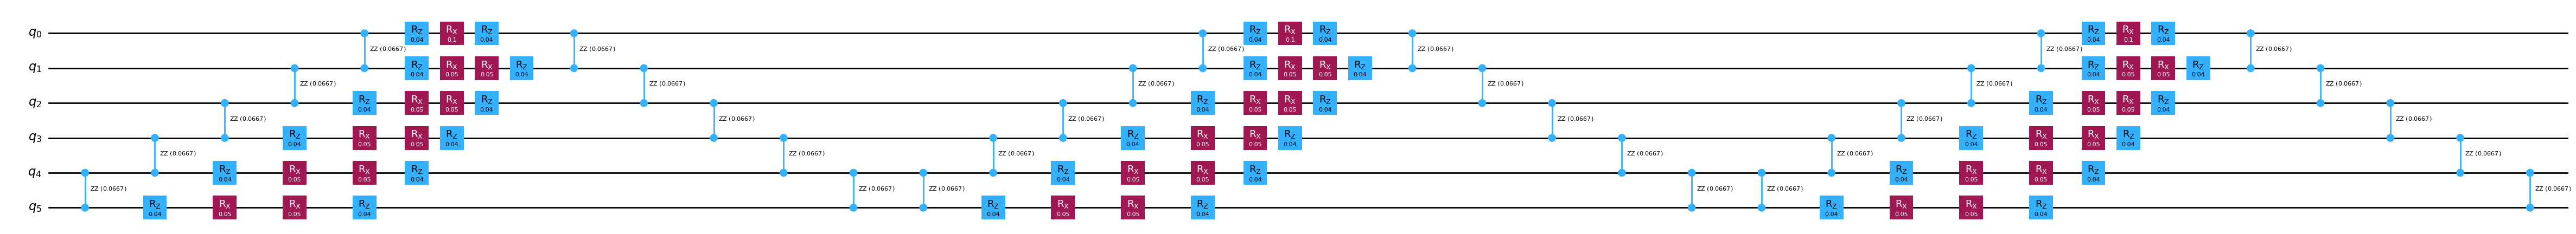

In [22]:
# Generate the subsequent circuit
subsequent_num_trotter_steps = 3
subsequent_evolution_time = 0.2

subsequent_circuit = generate_time_evolution_circuit(
        H_sparse,
        synthesis=SuzukiTrotter(reps=subsequent_num_trotter_steps),
        time=subsequent_evolution_time,
    )
subsequent_circuit.draw("mpl", fold=-1)

In [23]:
# Generate the AQC comparison circuit
aqc_comparison_num_trotter_steps = int(
    subsequent_num_trotter_steps / subsequent_evolution_time * aqc_evolution_time
)

aqc_comparison_circuit = generate_time_evolution_circuit(
        H_sparse,
        synthesis=SuzukiTrotter(reps=aqc_comparison_num_trotter_steps),
        time=aqc_evolution_time,
    )

In [24]:
# correct choice for reference circuit, should reflect the same physical system as the initial cirucit optimised with HS
from ropt_aqc.circuit_building import decompose_unitary_gate
ref_gates = get_brickwall_trotter_gates_spin_chain(t=t, n_sites=num_sites, n_repetitions=200,
                                                   hamiltonian=system, degree=degree, J=J, g=g, h=h)

ref_circuit = transform_to_bw_qc_unitarygate(num_sites=num_sites, system=system, gates=ref_gates)
native_ref_circuit = decompose_unitary_gate(ref_circuit)

In [25]:
import quimb.tensor as qtn
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit
from qiskit import transpile

native_ref_circuit_transpiled = transpile(
    native_ref_circuit,
    basis_gates=['rx', 'ry', 'rz', 'cx'],
    optimization_level=3
)

simulator_settings = QuimbSimulator(qtn.CircuitMPS, autodiff_backend="jax")
aqc_target_mps = tensornetwork_from_circuit(native_ref_circuit_transpiled, simulator_settings)


/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


In [26]:
import datetime
from scipy.optimize import OptimizeResult, minimize
from qiskit_addon_aqc_tensor.objective import OneMinusFidelity
from qiskit_addon_aqc_tensor.simulation import compute_overlap
from qiskit_addon_aqc_tensor.ansatz_generation import generate_ansatz_from_circuit
from ropt_aqc.brickwall_circuit import get_gates_per_layer
from itertools import chain
import jax.numpy as jnp

N_vals = [1,2,3,4,5,6,7,8,9,10]
data = []
# N_vals = [10]


for N in N_vals:
    print(f"\n=== Optimizing with N = {N} layers ===")

    gates_per_layer, layer_is_odd = get_gates_per_layer(
        gates_optimised, n_sites=num_sites, degree=degree, n_repetitions=n_repetitions, hamiltonian=system
    )

    gates_layer_structure = [len(layer) for layer in gates_per_layer[:N]]

    gates_subset = gates_per_layer[:N]
    layer_is_odd_subset = layer_is_odd[:N]
    gates_subset = list(chain(*gates_per_layer[:N]))
    gates_subset = jnp.asarray(gates_subset)
    print(np.array(gates_subset).shape)
    qc_optimised = transform_to_bw_qc_unitarygate(num_sites=num_sites, system = system, gates=gates_subset)

    native_circ = decompose_unitary_gate(qc_optimised)

    native_circuit_transpiled = transpile(
        native_circ, 
        basis_gates=['rx', 'ry', 'rz', 'cx'],
        optimization_level=3
    )
    good_mps = tensornetwork_from_circuit(native_circuit_transpiled, simulator_settings)
    starting_fidelity = abs(compute_overlap(good_mps, aqc_target_mps)) ** 2
    print("Starting fidelity:", starting_fidelity)

    aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(native_circ)


    print(f"AQC Comparison circuit: depth {aqc_comparison_circuit.depth()}")
    print(f"Target circuit:         depth {aqc_target_circuit.depth()}")
    print(f"Hybrid ansatz circuit:  depth {aqc_ansatz.depth()}, with {len(aqc_initial_parameters)} parameters")
    

    # Setting values for the optimization
    aqc_stopping_fidelity = 1
    aqc_max_iterations = 500

    stopping_point = 1.0 - aqc_stopping_fidelity
    objective = OneMinusFidelity(aqc_target_mps, aqc_ansatz, simulator_settings)

    def callback(intermediate_result: OptimizeResult):
        fidelity = 1 - intermediate_result.fun
        print(f"{datetime.datetime.now()} Intermediate result: Fidelity {fidelity:.8f}")
        if intermediate_result.fun < stopping_point:
            # Good enough for now
            raise StopIteration
        
    result = minimize(
        objective,
        aqc_initial_parameters,
        method="L-BFGS-B",
        jac=True,
        options={"maxiter": aqc_max_iterations},
        callback=callback,
    )
    if result.status not in (
        0,
        1,
        99,
    ):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
        raise RuntimeError(
            f"Optimization failed: {result.message} (status={result.status})"
        )

    print(f"Done after {result.nit} iterations.")
    aqc_final_parameters = result.x

    # Store results
    data.append({
        "Trotter_steps": n_repetitions,
        "circuit_layers": N,
        "Starting_fidelity": starting_fidelity,
        "Final_fidelity": 1 - result.fun
    })

# Optional: print as table
print("\n\n=== Compression Results Table ===")
print("Layers | Starting Fidelity | Final Fidelity")
for r in data:
    print(f"{r['circuit_layers']:>6} | {r['Starting_fidelity']!s:>21} | {r['Final_fidelity']:.6f}")



=== Optimizing with N = 1 layers ===
(3, 4, 4)
Starting fidelity: 0.7598277794831896
AQC Comparison circuit: depth 42
Target circuit:         depth 449
Hybrid ansatz circuit:  depth 3, with 45 parameters


/var/folders/zr/_ww60qvd18j868qh1qhtky300000gn/T/ipykernel_14900/3625623006.py:55: DeprecationWarning: The class ``qiskit_addon_aqc_tensor.objective.OneMinusFidelity`` is deprecated as of qiskit-addon-aqc-tensor 0.2.0. It will be removed no earlier than v0.4.0. This class has been renamed to ``MaximizeStateFidelity``.
  objective = OneMinusFidelity(aqc_target_mps, aqc_ansatz, simulator_settings)


2025-04-16 14:16:16.577640 Intermediate result: Fidelity 0.82357032
2025-04-16 14:16:16.578461 Intermediate result: Fidelity 0.89399610
2025-04-16 14:16:16.579059 Intermediate result: Fidelity 0.92522418
2025-04-16 14:16:16.579835 Intermediate result: Fidelity 0.92564415
2025-04-16 14:16:16.580565 Intermediate result: Fidelity 0.92654474
2025-04-16 14:16:16.581189 Intermediate result: Fidelity 0.92757026
2025-04-16 14:16:16.581792 Intermediate result: Fidelity 0.92967505
2025-04-16 14:16:16.582381 Intermediate result: Fidelity 0.93588149
2025-04-16 14:16:16.583539 Intermediate result: Fidelity 0.93963975
2025-04-16 14:16:16.584127 Intermediate result: Fidelity 0.94473707
2025-04-16 14:16:16.584695 Intermediate result: Fidelity 0.94605876
2025-04-16 14:16:16.585246 Intermediate result: Fidelity 0.94691580
2025-04-16 14:16:16.585829 Intermediate result: Fidelity 0.94706532
2025-04-16 14:16:16.586385 Intermediate result: Fidelity 0.94749081
2025-04-16 14:16:16.586929 Intermediate result: 

/var/folders/zr/_ww60qvd18j868qh1qhtky300000gn/T/ipykernel_14900/3625623006.py:55: DeprecationWarning: The class ``qiskit_addon_aqc_tensor.objective.OneMinusFidelity`` is deprecated as of qiskit-addon-aqc-tensor 0.2.0. It will be removed no earlier than v0.4.0. This class has been renamed to ``MaximizeStateFidelity``.
  objective = OneMinusFidelity(aqc_target_mps, aqc_ansatz, simulator_settings)


2025-04-16 14:16:17.439438 Intermediate result: Fidelity 0.90524259
2025-04-16 14:16:17.440414 Intermediate result: Fidelity 0.94117262
2025-04-16 14:16:17.441367 Intermediate result: Fidelity 0.95142128
2025-04-16 14:16:17.442189 Intermediate result: Fidelity 0.95357600
2025-04-16 14:16:17.442988 Intermediate result: Fidelity 0.95453245
2025-04-16 14:16:17.443770 Intermediate result: Fidelity 0.95684089
2025-04-16 14:16:17.444583 Intermediate result: Fidelity 0.95790848
2025-04-16 14:16:17.445399 Intermediate result: Fidelity 0.95866777
2025-04-16 14:16:17.446199 Intermediate result: Fidelity 0.95897068
2025-04-16 14:16:17.447004 Intermediate result: Fidelity 0.95916506
2025-04-16 14:16:17.447819 Intermediate result: Fidelity 0.96024333
2025-04-16 14:16:17.448618 Intermediate result: Fidelity 0.96125534
2025-04-16 14:16:17.449413 Intermediate result: Fidelity 0.96182647
2025-04-16 14:16:17.450233 Intermediate result: Fidelity 0.96254853
2025-04-16 14:16:17.451028 Intermediate result: 

In [27]:
import pandas as pd
file_path_ising = '/Users/aag/Documents/ropt-aqc/method_comparison/hybrid_Ising_results.csv'

# df = pd.DataFrame(data)
# df.to_csv(file_path_ising, index=False, header=True)
# df.to_csv(file_path_ising, index=False, mode="a", header=False)


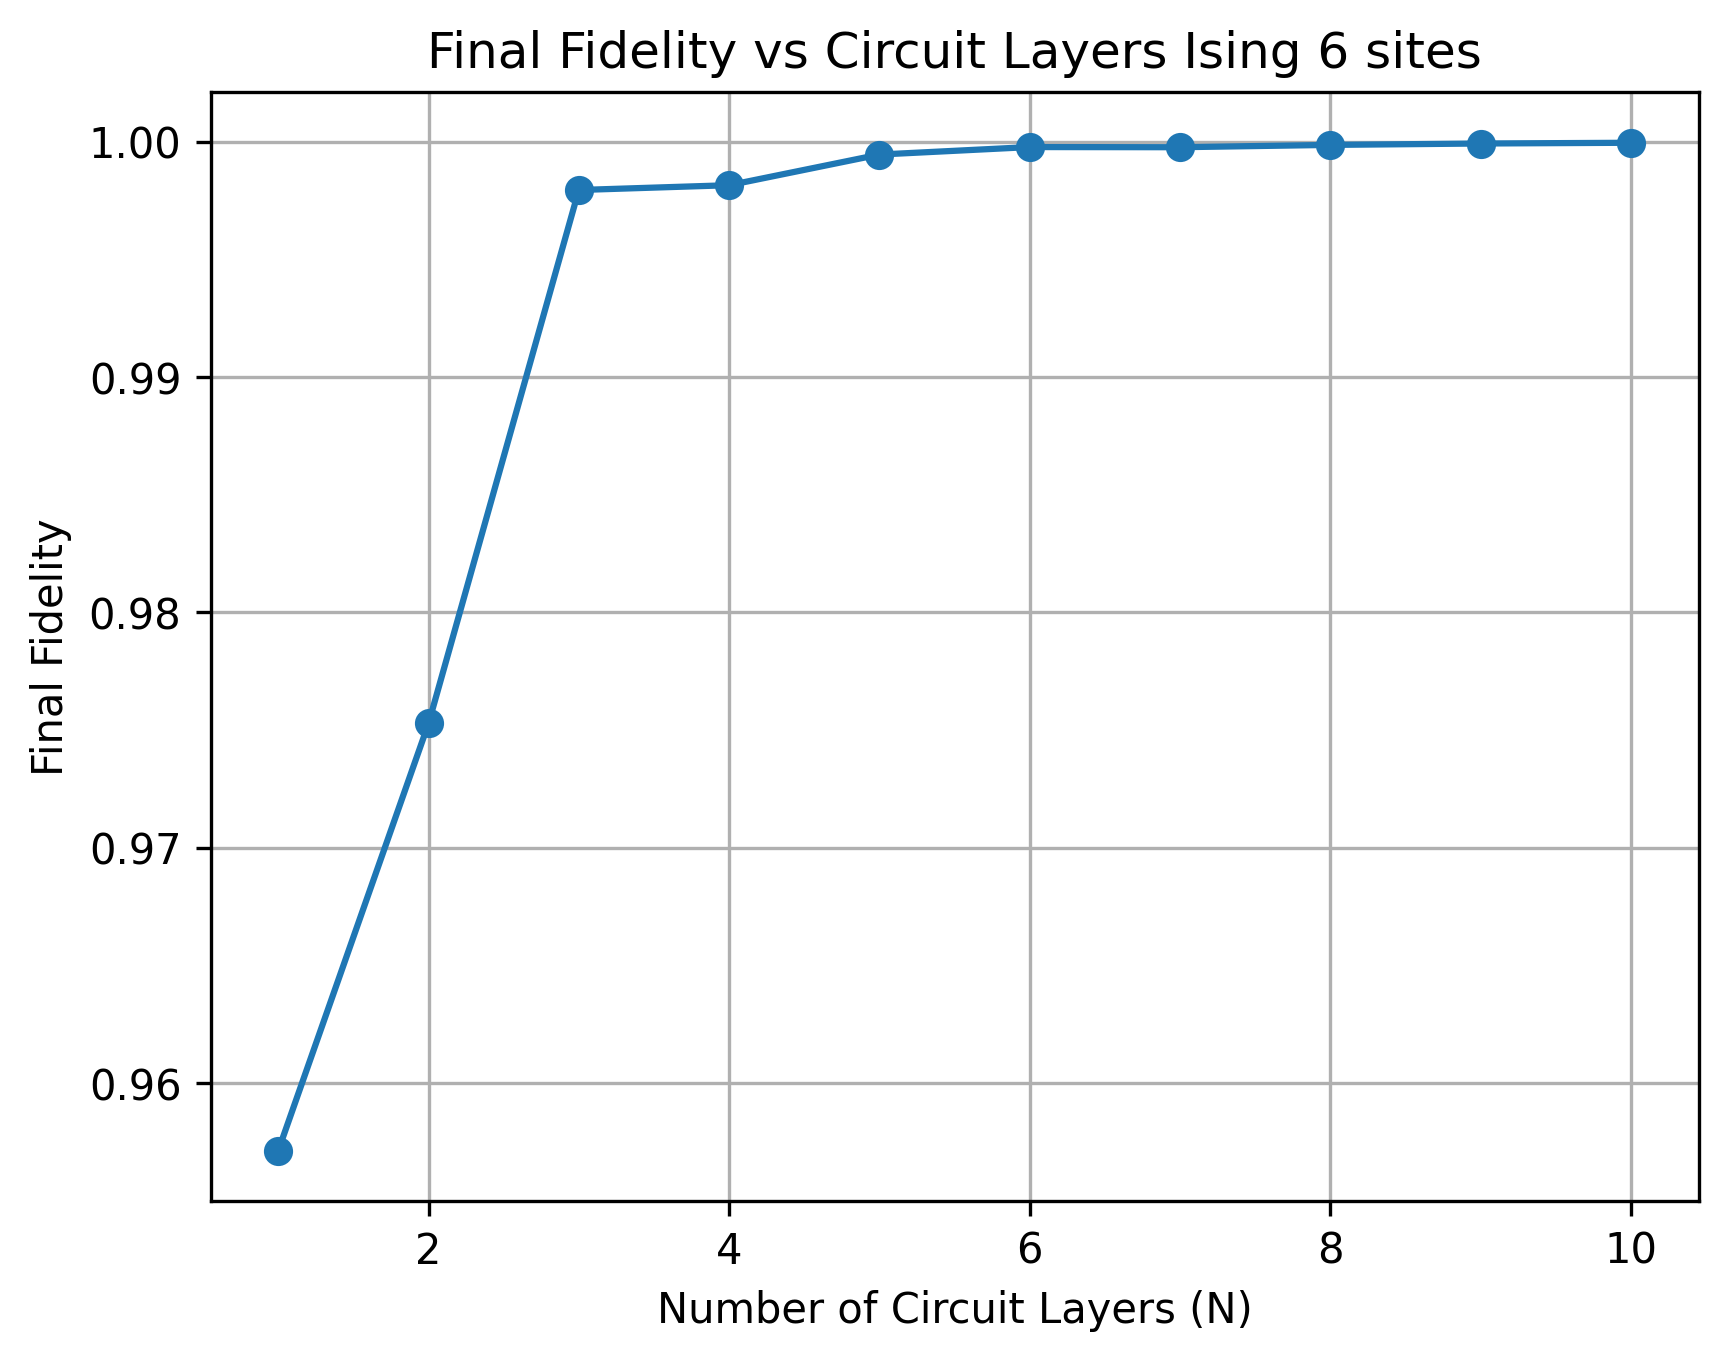

In [28]:
import matplotlib.pyplot as plt
df = pd.read_csv(file_path_ising)

# Plot MPO fidelity
plt.figure(dpi=300)
plt.plot(df['circuit_layers'], df['Final_fidelity'], marker='o')
plt.title('Final Fidelity vs Circuit Layers Ising 6 sites')
plt.xlabel('Number of Circuit Layers (N)')
plt.ylabel('Final Fidelity')
plt.grid(True)
plt.show()

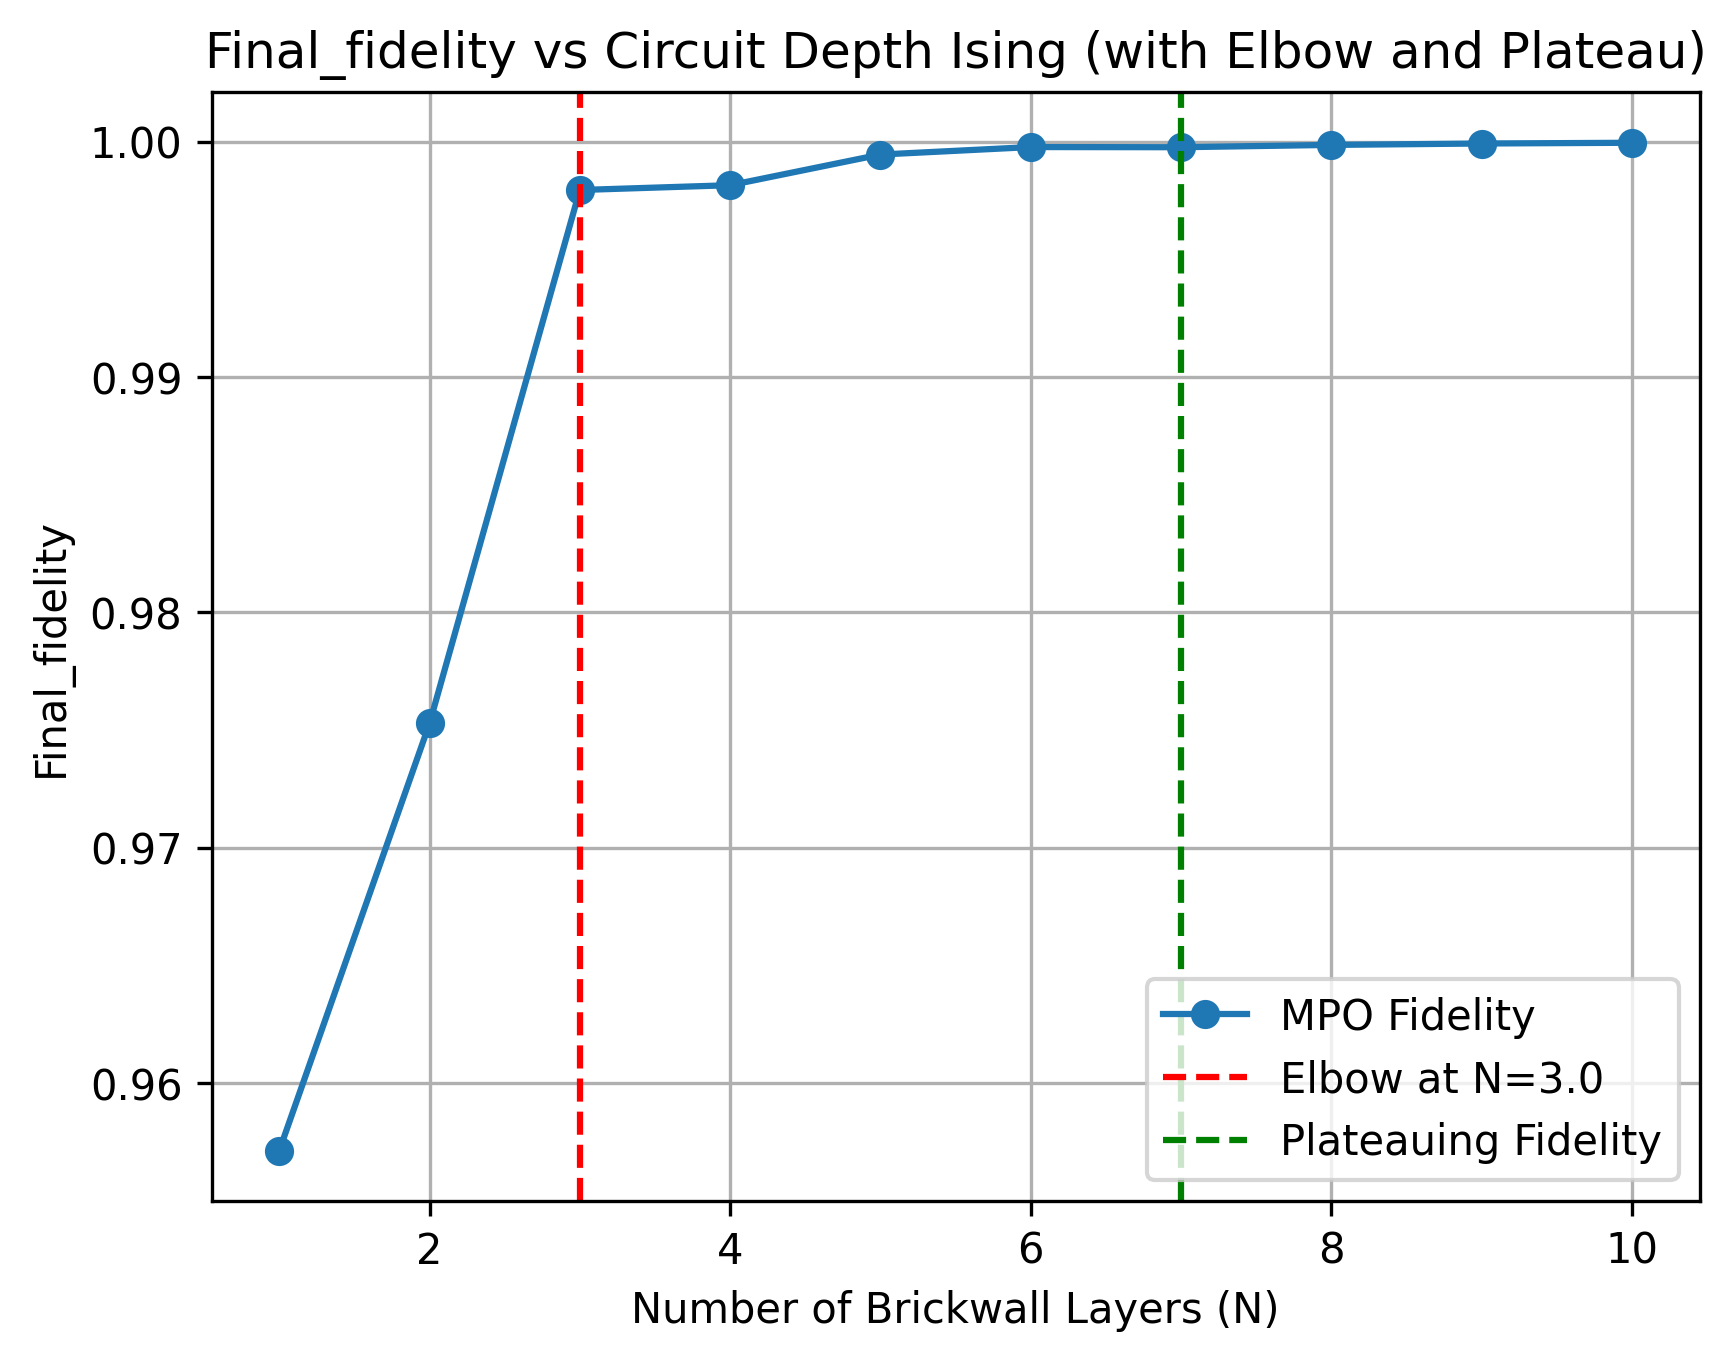


🔍 Suggested optimal compression depth: N = 7.0


In [29]:
from ropt_aqc.brickwall_opt import plot_fidelity

elbow_N_h, plateau_N_h = plot_fidelity(df, 'Final_fidelity', n_repetitions, system)

In [30]:
parameters = [float(param) for param in aqc_final_parameters]
print("Final parameters:", parameters)

Final parameters: [-7.267145641580308, 1.626080080529213, 1.5979251365985485, -1.347539346950925, 1.7448445980158325, -1.741470771575105, -1.4652731581137324, 1.4654175450277016, 1.5523824370478019, 1.6763194954755491, 1.6721537304234633, -1.544656493689403, -4.489132000539116, 1.391450284258799, -1.400884503349217, -4.1255529879912505, 1.528444936937717, 1.5552262669204273, 0.26343111261397695, 0.018668466550251617, 0.038352335126993514, -2.7997690151462122, 0.12716193292116104, 5.9117189559069745, -0.16228847388080983, 2.99301750302377, -0.004690301869285553, 0.08716651258224427, -0.02051559242577317, 0.08750991330254446, -2.9584225791268195, 3.2933739758962615, -2.786063942040526, -3.3220173846496297, -0.15183955992082618, -2.78171588338551, 0.2591251214080431, 0.017366461707670172, 0.03595110345431107, -2.9814635096343607, 0.14329097307114136, -0.007187164383558261, -0.32662877055770323, 3.0082202954630044, 5.899176333284642, -0.004170660390923947, -0.2490214253287026, 0.1957304607

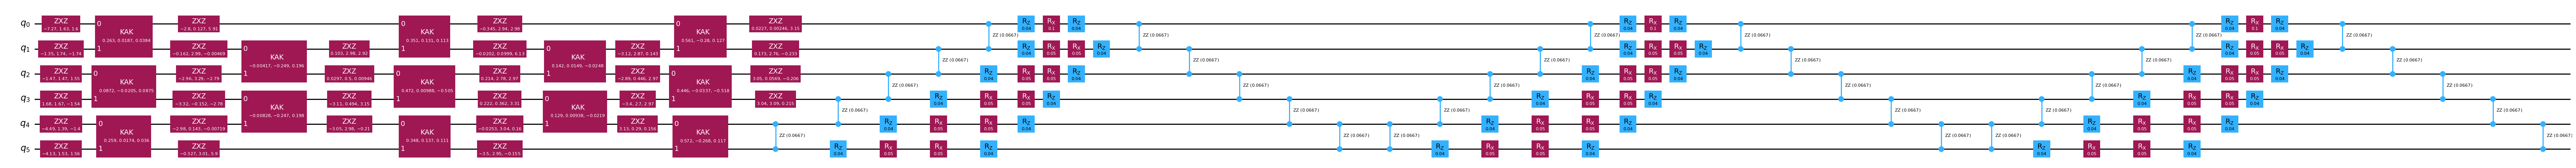

In [32]:
from ropt_aqc.circuit_building import truncate_ansatz

# N = plateau_N, elbow_N, (plateau_N + elbow_N)//2
N = 6

aqc_circuit_optimised = aqc_ansatz.assign_parameters(aqc_final_parameters)
truncated_ansatz = truncate_ansatz(aqc_circuit_optimised, N)
truncated_ansatz.compose(subsequent_circuit, inplace=True)
truncated_ansatz.draw("mpl", fold=-1)

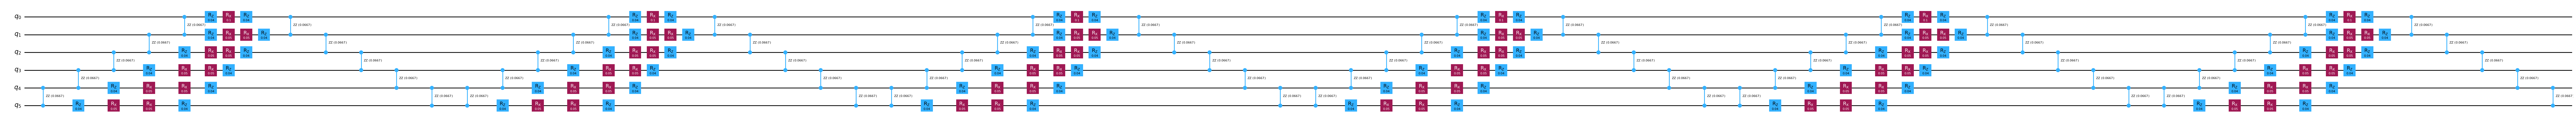

In [33]:
# merge comparison circuit with remaining time evolution circuit also
aqc_comparison_circuit.compose(subsequent_circuit, inplace=True)
aqc_comparison_circuit.draw("mpl", fold=-1)

In [34]:
print(f"AQC Comparison circuit:    depth {aqc_comparison_circuit.depth()}")
print(f"Truncated Ansatz circuit:  depth {truncated_ansatz.depth()}")

AQC Comparison circuit:    depth 84
Truncated Ansatz circuit:  depth 52


In [35]:
from qiskit.quantum_info import Operator
reference_unitary = Operator(truncated_ansatz)

Observable info: SparsePauliOp(['IIZIZI'],
              coeffs=[1.+0.j])
Circuit depth: 115


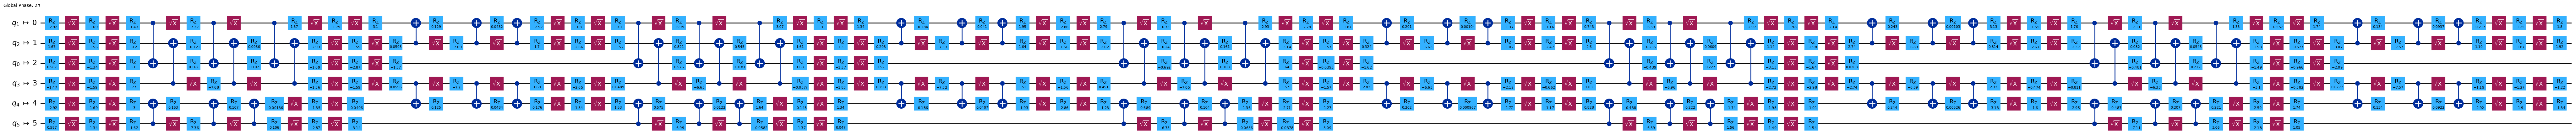

In [50]:
# Visualise optimised circuit
#  transpiler optimises cirucit to fit a 1D chain of qubits, reducing the noise impacting the cirucit fidelity
from qiskit import transpile
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (num_sites // 2 - 1, num_sites // 2), 1.0)], num_qubits=num_sites
)

backend = GenericBackendV2(num_qubits=num_sites)
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pass_manager.run(aqc_final_circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)
print("Observable info:", isa_observable)
print("Circuit depth:", isa_circuit.depth())
isa_circuit.draw("mpl", fold=-1, idle_wires=False)

Observable info: SparsePauliOp(['IIZIZI'],
              coeffs=[1.+0.j])
Circuit depth: 120


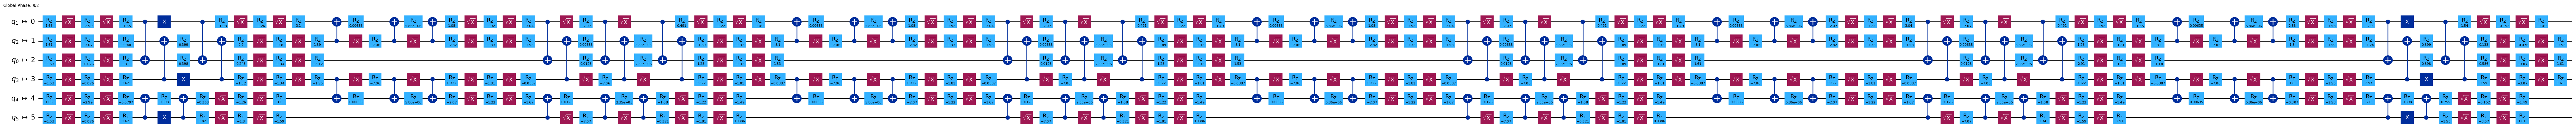

In [51]:
# Cirucit before optimisation
isa_circuit_i = pass_manager.run(qc_initial)
isa_observable_i = observable.apply_layout(isa_circuit_i.layout)

print("Observable info:", isa_observable_i)
print("Circuit depth:", isa_circuit_i.depth())
isa_circuit_i.draw("mpl", fold=-1, idle_wires=False)

In [46]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit import transpile

backend = GenericBackendV2(num_qubits=num_sites)

transpiled = transpile(qc_optimised, backend=backend, optimization_level=3)

print("Ideal circuit depth:", qc_optimised.depth())
print("Transpiled circuit depth:", transpiled.depth())

Ideal circuit depth: 2
Transpiled circuit depth: 27


In [47]:
ideal_cx = qc_optimised.count_ops().get('cx', 0)
actual_cx = transpiled.count_ops().get('cx', 0)

print("Transpiled Circuit Gate counts:", transpiled.count_ops())
print("Transpiled CNOT count: ", actual_cx)
print("Ideal CNOT count: ", ideal_cx)

Transpiled Circuit Gate counts: OrderedDict({'rz': 63, 'sx': 42, 'cx': 15})
Transpiled CNOT count:  15
Ideal CNOT count:  0


In [ ]:
from qiskit.quantum_info import Statevector, state_fidelity
n_qubits = num_sites

rand_vec = np.random.rand(2**n_qubits) + 1j * np.random.rand(2**n_qubits)
rand_vec /= np.linalg.norm(rand_vec)

states = {
    "|0...0⟩": Statevector.from_label("0" * n_qubits),
    "|+++...+⟩": Statevector.from_label("+" * n_qubits),
    "|1...1⟩": Statevector.from_label("1" * n_qubits),
    "random": Statevector(rand_vec)
}

In [ ]:
for name, psi_in in states.items():
    psi_initial = psi_in.evolve(qc_initial)
    psi_optimised = psi_in.evolve(qc_optimised)
    
    fidelity = state_fidelity(psi_initial, psi_optimised)
    print(f"Input: {name}")
    print(f"State fidelity (Initial vs Optimized): {fidelity:.6f}")
    
    # Optional: show L2 norm difference
    diff_norm = np.linalg.norm(psi_initial.data - psi_optimised.data)
    print(f"State L2 difference: {diff_norm:.6e}\n")


In [ ]:
import matplotlib.pyplot as plt

def plot_state_evolution_comparison(qc_initial, qc_optimized, n_qubits):
    # Define initial states
    rand_vec = np.random.rand(2**n_qubits) + 1j * np.random.rand(2**n_qubits)
    rand_vec /= np.linalg.norm(rand_vec)

    states = {
        "|0...0⟩": Statevector.from_label("0" * n_qubits),
        "|1...1⟩": Statevector.from_label("1" * n_qubits),
        "|+++...+⟩": Statevector.from_label("+" * n_qubits),
        "Random ψ": Statevector(rand_vec)
    }

    # Track results
    fidelities = []
    differences = []
    labels = []

    for label, psi_in in states.items():
        psi_init = psi_in.evolve(qc_initial)
        psi_opt = psi_in.evolve(qc_optimized)

        fid = state_fidelity(psi_init, psi_opt)
        diff = np.linalg.norm(psi_init.data - psi_opt.data)

        fidelities.append(fid)
        differences.append(diff)
        labels.append(label)

        print(f"{label}:")
        print(f"  Fidelity        = {fid:.6f}")
        print(f"  L2 Difference   = {diff:.6e}\n")

    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 5))

    bar_width = 0.35
    x = np.arange(len(labels))

    ax1.bar(x - bar_width/2, fidelities, bar_width, label="Fidelity")
    ax1.bar(x + bar_width/2, differences, bar_width, label="L2 Difference")

    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.set_ylabel("Value")
    ax1.set_title("Comparison of State Evolution: Initial vs Optimized Circuit")
    ax1.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_state_evolution_comparison(qc_initial, qc_optimised, num_sites)

In [ ]:
from qiskit.visualization import plot_state_city
from qiskit.quantum_info import Statevector

# Simulate state evolution
initial_state = Statevector.from_label('0' * qc_optimised.num_qubits)
final_state = initial_state.evolve(qc_optimised)


In [ ]:
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')

qc_initial.measure_all()
transpiled_circuit_i = transpile(qc_initial, backend)
job1 = backend.run(transpile(transpiled_circuit_i, backend))
result1 = job1.result()
counts1 = result1.get_counts()

qc_optimised.measure_all()
transpiled_circuit = transpile(qc_optimised, backend)
job2 = backend.run(transpiled_circuit, shots=1000)
result2 = job2.result()
counts2 = result2.get_counts()

plot_histogram([counts1, counts2], legend=["Initial", "Optimized"])

#  optimized circuit appears to project the input toward a dominant eigenstate of the learned evolution — 
# likely trying to approximate something like:∣ψt)⟩≈∣ground state or reference state⟩



In [ ]:
# Statevector Fidelity Sweep Across Input States
from qiskit.quantum_info import Statevector, state_fidelity

def remove_measurements(circuit):
    qc = circuit.remove_final_measurements(inplace=False)
    return qc

qc_init_clean = remove_measurements(qc_initial)
qc_opt_clean = remove_measurements(qc_optimised)


def sweep_fidelities(qc_init, qc_opt, n_qubits):
    rand_vec = np.random.rand(2**n_qubits) + 1j * np.random.rand(2**n_qubits)
    rand_vec /= np.linalg.norm(rand_vec)

    states = [
        Statevector.from_label("0" * n_qubits),
        Statevector.from_label("1" * n_qubits),
        Statevector.from_label("+" * n_qubits),
        Statevector.from_label("-" * n_qubits),
        Statevector.from_label("r" * n_qubits),  # Y-basis (right-circular)
        Statevector(rand_vec)       
        ]

    fids = []
    for psi in states:
        psi = Statevector(psi)  # ensure proper Qiskit type
        psi_init = psi.evolve(qc_init)
        psi_opt = psi.evolve(qc_opt)
        fids.append(state_fidelity(psi_init, psi_opt))

    return fids


sweep_fidelities(qc_init_clean, qc_opt_clean, num_sites)

In [ ]:
import matplotlib.pyplot as plt

labels = ["|0⟩", "|1⟩", "|+⟩", "|-⟩", "|r⟩", "Random"]
fids = sweep_fidelities(qc_init_clean, qc_opt_clean, num_sites)

plt.bar(labels, fids)
plt.ylim(0, 1.05)
plt.title("Fidelity vs Input State")
plt.ylabel("Fidelity")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
from qiskit.quantum_info import Statevector, SparsePauliOp

# Final evolved state
final_sv = Statevector(qc_optimised)

# Define observable
observable = SparsePauliOp.from_list([("ZZ", 0.5), ("II", -0.5)])  # example

# Compute ⟨ψ|O|ψ⟩
expectation = final_sv.expectation_value(observable)


In [ ]:
from ropt_aqc.circuit_building import get_step_size

step_size = get_step_size(system, num_sites)
print(step_size)
num_steps = len(gates_optimised) // step_size
print(num_steps)

Heisenberg

In [95]:
# Heisenberg
t = 0.25
h = 0.75
system = 'heisenberg'

terms_h, params_h = get_hamiltonian_terms(num_qubits=num_sites, system=system, J=[1.0, 1.0, -0.5], h=[0.75, 0.0, 0.0])

J= params_h['J']
h= params_h['h']

In [54]:
from ropt_aqc.spin_systems import get_brickwall_trotter_gates_spin_chain

gates_heisenberg = get_brickwall_trotter_gates_spin_chain(t=t, n_sites=num_sites, n_repetitions=n_repetitions, hamiltonian=system, degree=degree, J=J, h=h)

In [55]:
# Matrices for qc
from ropt_aqc.brickwall_circuit import get_initial_gates

gates_initial_h = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=False, J=-J, h=h)
print(np.array(gates_initial_h).shape) 

(28, 4, 4)


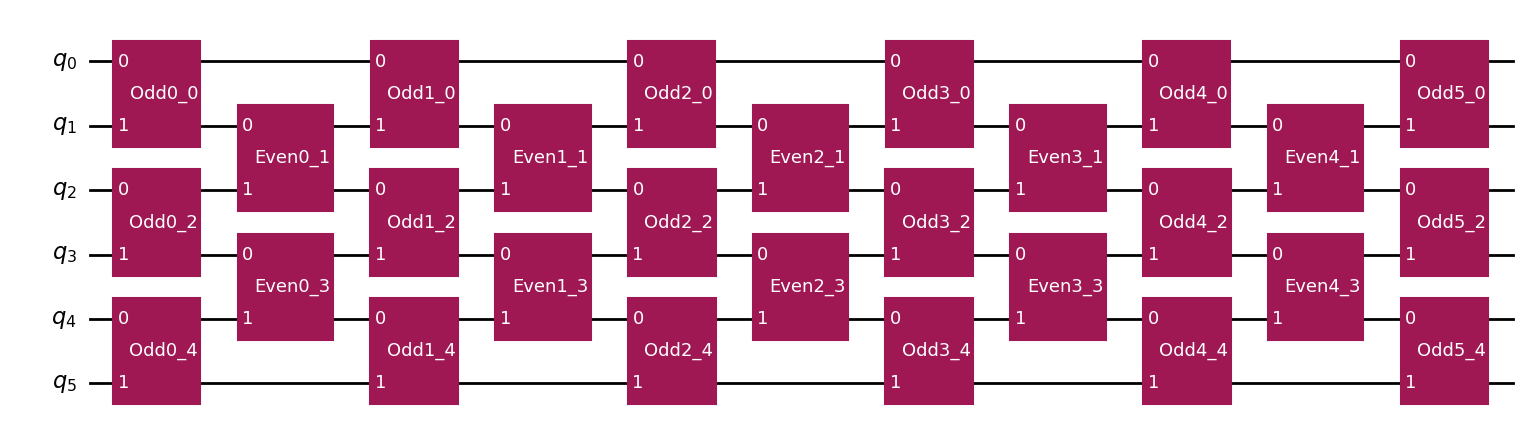

In [57]:
from ropt_aqc.circuit_building import transform_to_bw_qc_unitarygate

qc_initial_h = transform_to_bw_qc_unitarygate(num_sites=num_sites, system = system, gates=gates_initial_h, pauli_terms=terms)
qc_initial_h.draw('mpl')

In [58]:
# TN for optimisation
from ropt_aqc.brickwall_circuit import get_initial_gates
gates_h = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=True, J=J, h=h)
print(np.array(gates_h).shape)  # Should be (N, 4, 4) for 2-qubit gates

(28, 2, 2, 2, 2)


In [60]:
from ropt_aqc.save_model import load_reference
import os
import yaml
repo_root = "/Users/aag/Documents/ropt-aqc/"
config_file = os.path.join(repo_root, "run", system, "configs", "config.yml") 

with open(config_file, "r") as f:
    config = yaml.safe_load(f)

config['ref_nbr'] = n_repetitions

config['reference_dir'] = f'/Users/aag/Documents/ropt-aqc/run/{system}/reference'

U_ref, t, _, _, _, _, _, _, _, J, h= load_reference(config['reference_dir'], config['n_sites'], config['ref_nbr'])

In [61]:
from ropt_aqc.tn_helpers import left_to_right_QR_sweep

U_ref = left_to_right_QR_sweep(U_ref, get_norm=False, normalize=config['normalize_reference'])
print("U_ref shape:", [m.shape for m in U_ref])

U_ref shape: [(1, 2, 2, 4), (4, 2, 2, 16), (16, 2, 2, 33), (33, 2, 2, 16), (16, 2, 2, 4), (4, 2, 2, 1)]


Start Riemannian ADAM optimization ...
	 0 	Current cost:  3.1528563186888903e-06
	 1 	Current cost:  0.0008704070581657675
	 2 	Current cost:  0.00010205318896394644
	 3 	Current cost:  0.00020570333941272168
	 4 	Current cost:  0.0003747591539728923
	 5 	Current cost:  0.0003463962374810059
	 6 	Current cost:  0.00019490333482496958
	 7 	Current cost:  4.7192160652187454e-05
	 8 	Current cost:  4.02600354267868e-05
	 9 	Current cost:  0.0001544120969343421
	 10 	Current cost:  0.00021672882708201335
	 11 	Current cost:  0.0001511149113468946
	 12 	Current cost:  5.0233636375907054e-05
	 13 	Current cost:  1.6454252889319676e-05
	 14 	Current cost:  5.0094471147899e-05
	 15 	Current cost:  8.743822133450152e-05
	 16 	Current cost:  9.318634349497756e-05
	 17 	Current cost:  7.339485043234006e-05
	 18 	Current cost:  4.255021176136076e-05
	 19 	Current cost:  1.761348321149825e-05
	 20 	Current cost:  1.7393349002414737e-05
	 21 	Current cost:  4.016918793725566e-05
	 22 	Current cost:

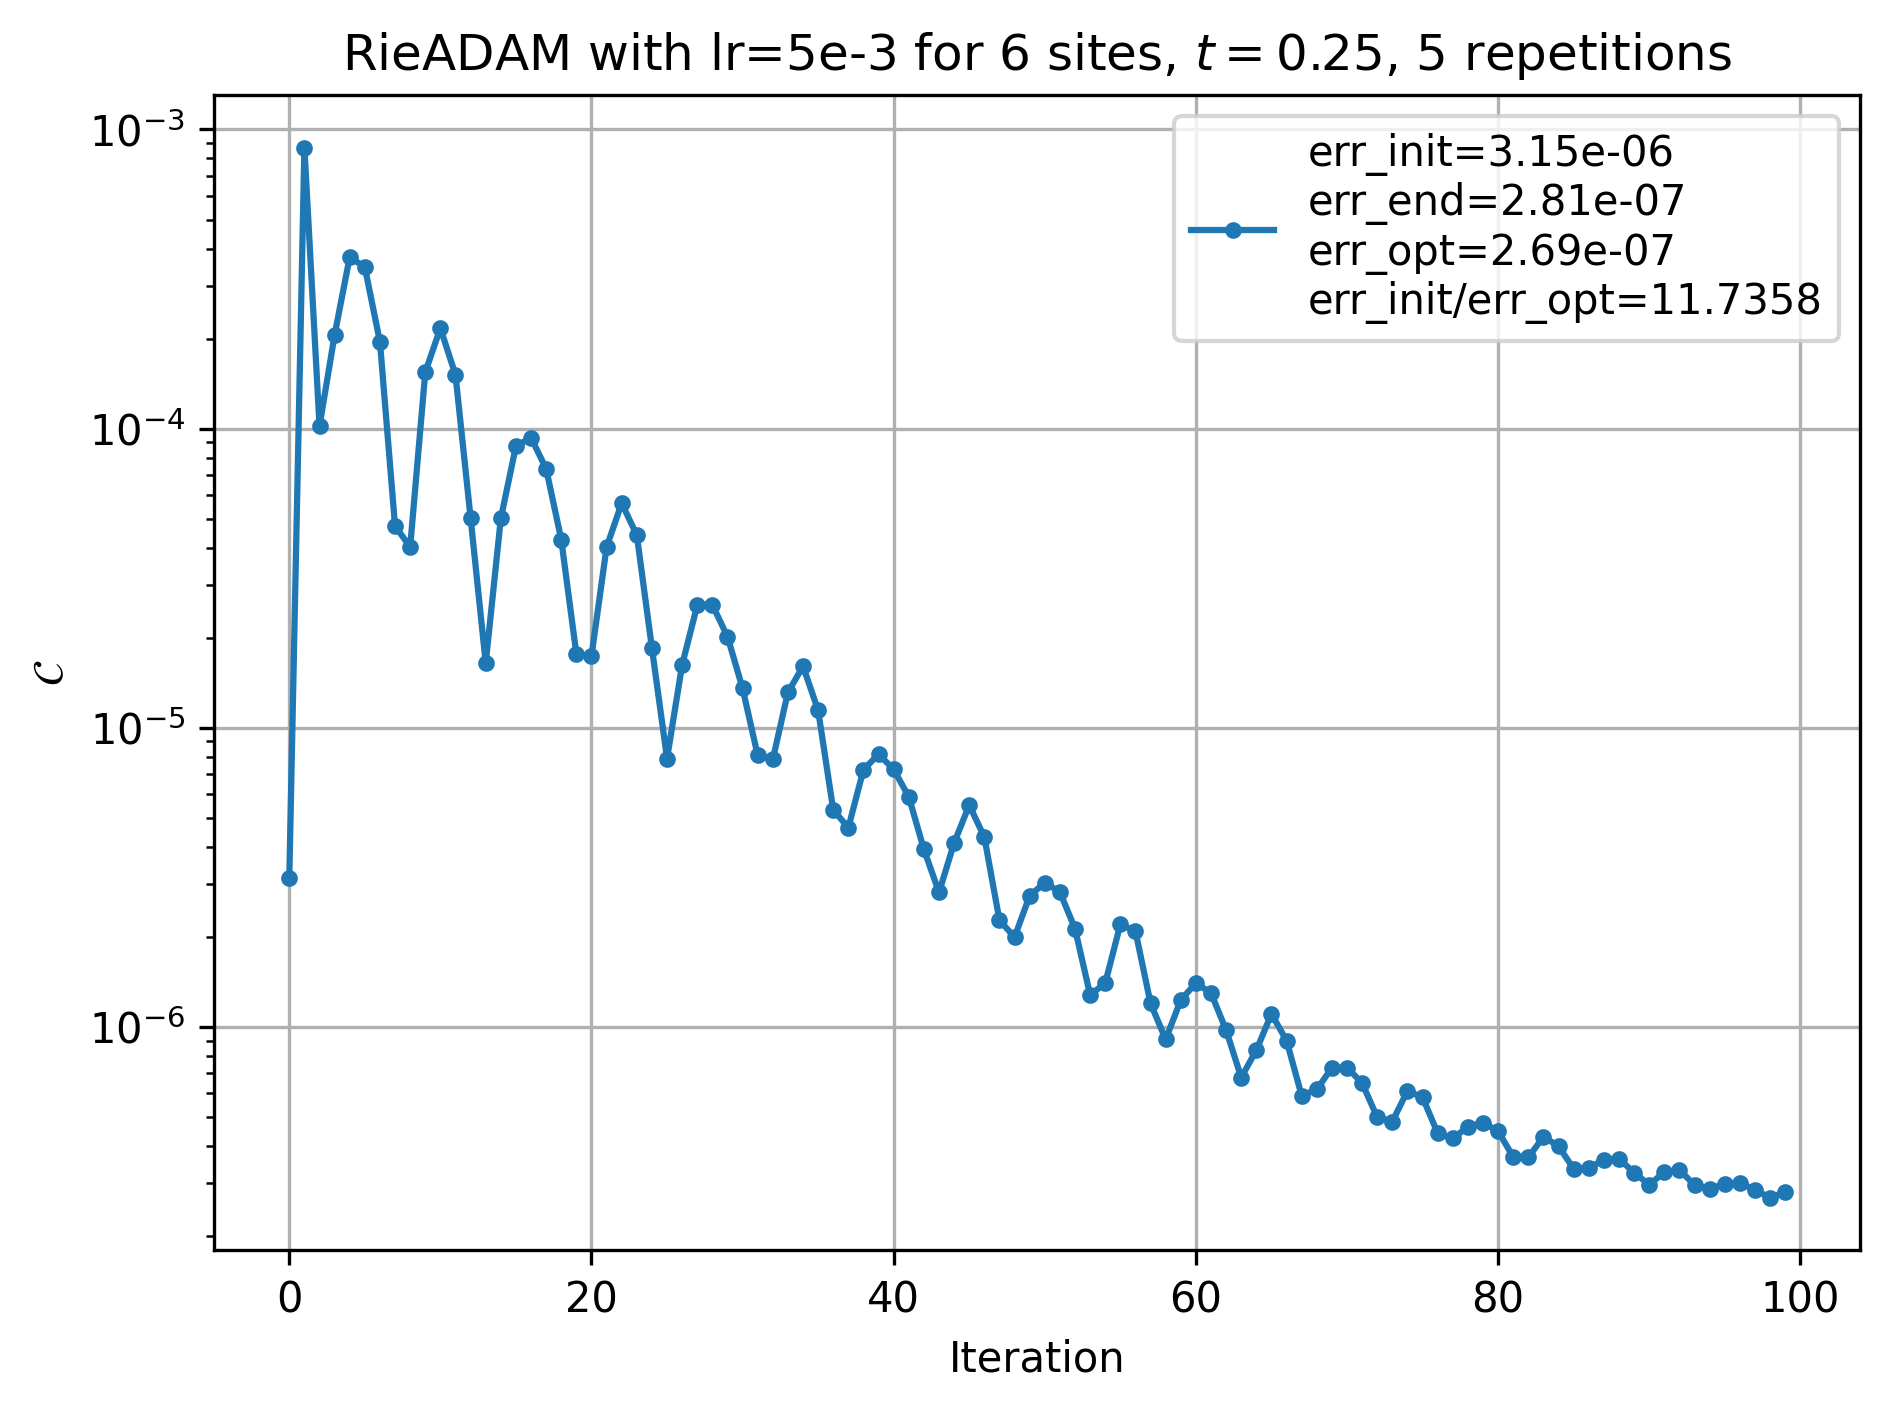

In [74]:
from ropt_aqc.brickwall_opt import optimize_swap_network_circuit_RieADAM
import pdb

gates_optimised_h, err_iter = optimize_swap_network_circuit_RieADAM(config, U_ref, gates_h)

In [75]:
gates_optimised_h = gates_optimised_h.reshape((len(gates_optimised_h), 4, 4))
np.allclose(gates_optimised_h, gates_initial_h)  # Should be False

False

In [76]:
from ropt_aqc.initialise_hamiltonians import hamiltonian_to_sparse_observable
H_sparse_h = hamiltonian_to_sparse_observable(terms_h, num_qubits=num_sites)
print(H_sparse_h)

<SparseObservable with 21 terms on 6 qubits: (1+0j)(X_5 X_4) + (1+0j)(Y_5 Y_4) + (-0.5+0j)(Z_5 Z_4) + (1+0j)(X_4 X_3) + (1+0j)(Y_4 Y_3) + (-0.5+0j)(Z_4 Z_3) + (1+0j)(X_3 X_2) + (1+0j)(Y_3 Y_2) + (-0.5+0j)(Z_3 Z_2) + (1+0j)(X_2 X_1) + (1+0j)(Y_2 Y_1) + (-0.5+0j)(Z_2 Z_1) + (1+0j)(X_1 X_0) + (1+0j)(Y_1 Y_0) + (-0.5+0j)(Z_1 Z_0) + (0.75+0j)(X_5) + (0.75+0j)(X_4) + (0.75+0j)(X_3) + (0.75+0j)(X_2) + (0.75+0j)(X_1) + (0.75+0j)(X_0)>


In [77]:
# one option for reference cirucit
# initial time evolution
# construct initial state
from qiskit import QuantumCircuit

initial_state_h = QuantumCircuit(num_sites)
for i in range(num_sites):
    if i % 2:
        initial_state_h.x(i)

from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

# Generate the AQC target circuit (initial segment)
aqc_evolution_time = 0.2
aqc_target_num_trotter_steps = 32

aqc_target_circuit_h = initial_state.copy()
aqc_target_circuit_h.compose(
    generate_time_evolution_circuit(
        H_sparse_h,
        synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

In [78]:
aqc_comparison_circuit_h = initial_state_h.copy()
aqc_comparison_circuit_h.compose(
    generate_time_evolution_circuit(
        H_sparse_h,
        synthesis=SuzukiTrotter(reps=3),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

In [79]:
# second option for reference circuit 
from ropt_aqc.circuit_building import decompose_unitary_gate
ref_gates_h = get_brickwall_trotter_gates_spin_chain(t=t, n_sites=num_sites, n_repetitions=64,
                                                   hamiltonian=system, degree=degree, J=J, h=h)

ref_circuit_h = transform_to_bw_qc_unitarygate(num_sites=num_sites, system=system, gates=ref_gates_h)
native_ref_circuit_h = decompose_unitary_gate(ref_circuit_h)

In [80]:
import quimb.tensor as qtn
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit
from qiskit import transpile

native_ref_circuit_transpiled_h = transpile(
    native_ref_circuit_h,
    basis_gates=['rx', 'ry', 'rz', 'cx'],
    optimization_level=3
)

simulator_settings = QuimbSimulator(qtn.CircuitMPS, autodiff_backend="jax")
aqc_target_mps_h= tensornetwork_from_circuit(native_ref_circuit_transpiled_h, simulator_settings)


In [86]:
import datetime
from scipy.optimize import OptimizeResult, minimize
from qiskit_addon_aqc_tensor.objective import OneMinusFidelity
from qiskit_addon_aqc_tensor.simulation import compute_overlap
from qiskit_addon_aqc_tensor.ansatz_generation import generate_ansatz_from_circuit
from ropt_aqc.brickwall_circuit import get_gates_per_layer
from itertools import chain
import jax.numpy as jnp

N_vals = [5,6,7,8,9,10,11]
data = []

for N in N_vals:
    print(f"\n=== Optimizing with N = {N} layers ===")

    gates_per_layer_h, layer_is_odd_h = get_gates_per_layer(
        gates_optimised_h, n_sites=num_sites, degree=degree, n_repetitions=n_repetitions, hamiltonian=system
    )

    gates_layer_structure_h = [len(layer) for layer in gates_per_layer_h[:N]]

    gates_subset_h = gates_per_layer_h[:N]
    layer_is_odd_subset_h = layer_is_odd_h[:N]
    gates_subset_h = list(chain(*gates_per_layer_h[:N]))
    gates_subset_h = jnp.asarray(gates_subset_h)
    print(np.array(gates_subset).shape)
    qc_optimised_h = transform_to_bw_qc_unitarygate(num_sites=num_sites, system = system, gates=gates_subset_h)

    native_circ_h = decompose_unitary_gate(qc_optimised_h)

    native_circuit_transpiled_h = transpile(
        native_circ_h, 
        basis_gates=['rx', 'ry', 'rz', 'cx'],
        optimization_level=3
    )
    good_mps_h = tensornetwork_from_circuit(native_circuit_transpiled_h, simulator_settings)
    starting_fidelity_h = abs(compute_overlap(good_mps_h, aqc_target_mps_h)) ** 2
    print("Starting fidelity:", starting_fidelity_h)

    aqc_ansatz_h, aqc_initial_parameters_h = generate_ansatz_from_circuit(native_circ_h)

    print(f"AQC Comparison circuit: depth {aqc_comparison_circuit_h.depth()}")
    print(f"Target circuit:         depth {aqc_target_circuit_h.depth()}")
    print(f"Hybrid ansatz circuit:  depth {aqc_ansatz_h.depth()}, with {len(aqc_initial_parameters_h)} parameters")
    

    # Setting values for the optimization
    aqc_stopping_fidelity = 1
    aqc_max_iterations = 500

    stopping_point = 1.0 - aqc_stopping_fidelity
    objective = OneMinusFidelity(aqc_target_mps_h, aqc_ansatz_h, simulator_settings)

    def callback(intermediate_result: OptimizeResult):
        fidelity = 1 - intermediate_result.fun
        print(f"{datetime.datetime.now()} Intermediate result: Fidelity {fidelity:.8f}")
        if intermediate_result.fun < stopping_point:
            # Good enough for now
            raise StopIteration
        
    result = minimize(
        objective,
        aqc_initial_parameters_h,
        method="L-BFGS-B",
        jac=True,
        options={"maxiter": aqc_max_iterations},
        callback=callback,
    )
    if result.status not in (
        0,
        1,
        99,
    ):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
        raise RuntimeError(
            f"Optimization failed: {result.message} (status={result.status})"
        )

    print(f"Done after {result.nit} iterations.")
    aqc_final_parameters_h = result.x

    # Store results
    data.append({
        "Trotter_steps": n_repetitions,
        "circuit_layers": N,
        "Starting_fidelity": starting_fidelity_h,
        "Final_fidelity": 1 - result.fun
    })

# Optional: print as table
print("\n\n=== Compression Results Table ===")
print("Layers | Starting Fidelity | Final Fidelity")
for r in data:
    print(f"{r['circuit_layers']:>6} | {r['Starting_fidelity']!s:>21} | {r['Final_fidelity']:.6f}")



=== Optimizing with N = 5 layers ===
(25, 4, 4)
Starting fidelity: 0.9335351394147491
AQC Comparison circuit: depth 97
Target circuit:         depth 1025
Hybrid ansatz circuit:  depth 11, with 135 parameters


/var/folders/zr/_ww60qvd18j868qh1qhtky300000gn/T/ipykernel_71034/755602669.py:52: DeprecationWarning: The class ``qiskit_addon_aqc_tensor.objective.OneMinusFidelity`` is deprecated as of qiskit-addon-aqc-tensor 0.2.0. It will be removed no earlier than v0.4.0. This class has been renamed to ``MaximizeStateFidelity``.
  objective = OneMinusFidelity(aqc_target_mps_h, aqc_ansatz_h, simulator_settings)


2025-04-14 17:07:03.564214 Intermediate result: Fidelity 0.97833687
2025-04-14 17:07:03.566157 Intermediate result: Fidelity 0.99012728
2025-04-14 17:07:03.567890 Intermediate result: Fidelity 0.99716606
2025-04-14 17:07:03.569636 Intermediate result: Fidelity 0.99861892
2025-04-14 17:07:03.571488 Intermediate result: Fidelity 0.99933181
2025-04-14 17:07:03.573343 Intermediate result: Fidelity 0.99941647
2025-04-14 17:07:03.575093 Intermediate result: Fidelity 0.99955985
2025-04-14 17:07:03.576783 Intermediate result: Fidelity 0.99970636
2025-04-14 17:07:03.578545 Intermediate result: Fidelity 0.99983732
2025-04-14 17:07:03.580223 Intermediate result: Fidelity 0.99990556
2025-04-14 17:07:03.582217 Intermediate result: Fidelity 0.99994040
2025-04-14 17:07:03.583977 Intermediate result: Fidelity 0.99995860
2025-04-14 17:07:03.585751 Intermediate result: Fidelity 0.99997383
2025-04-14 17:07:03.587537 Intermediate result: Fidelity 0.99997593
2025-04-14 17:07:03.589092 Intermediate result: 

In [96]:
import pandas as pd
file_path_heisenberg = '/Users/aag/Documents/ropt-aqc/method_comparison/hybrid_Heisenberg_results.csv'

# df = pd.DataFrame(data)
# df.to_csv(file_path_heisenberg, index=False, header=True)
# df.to_csv(file_path_heisenberg, index=False, mode="a", header=False)

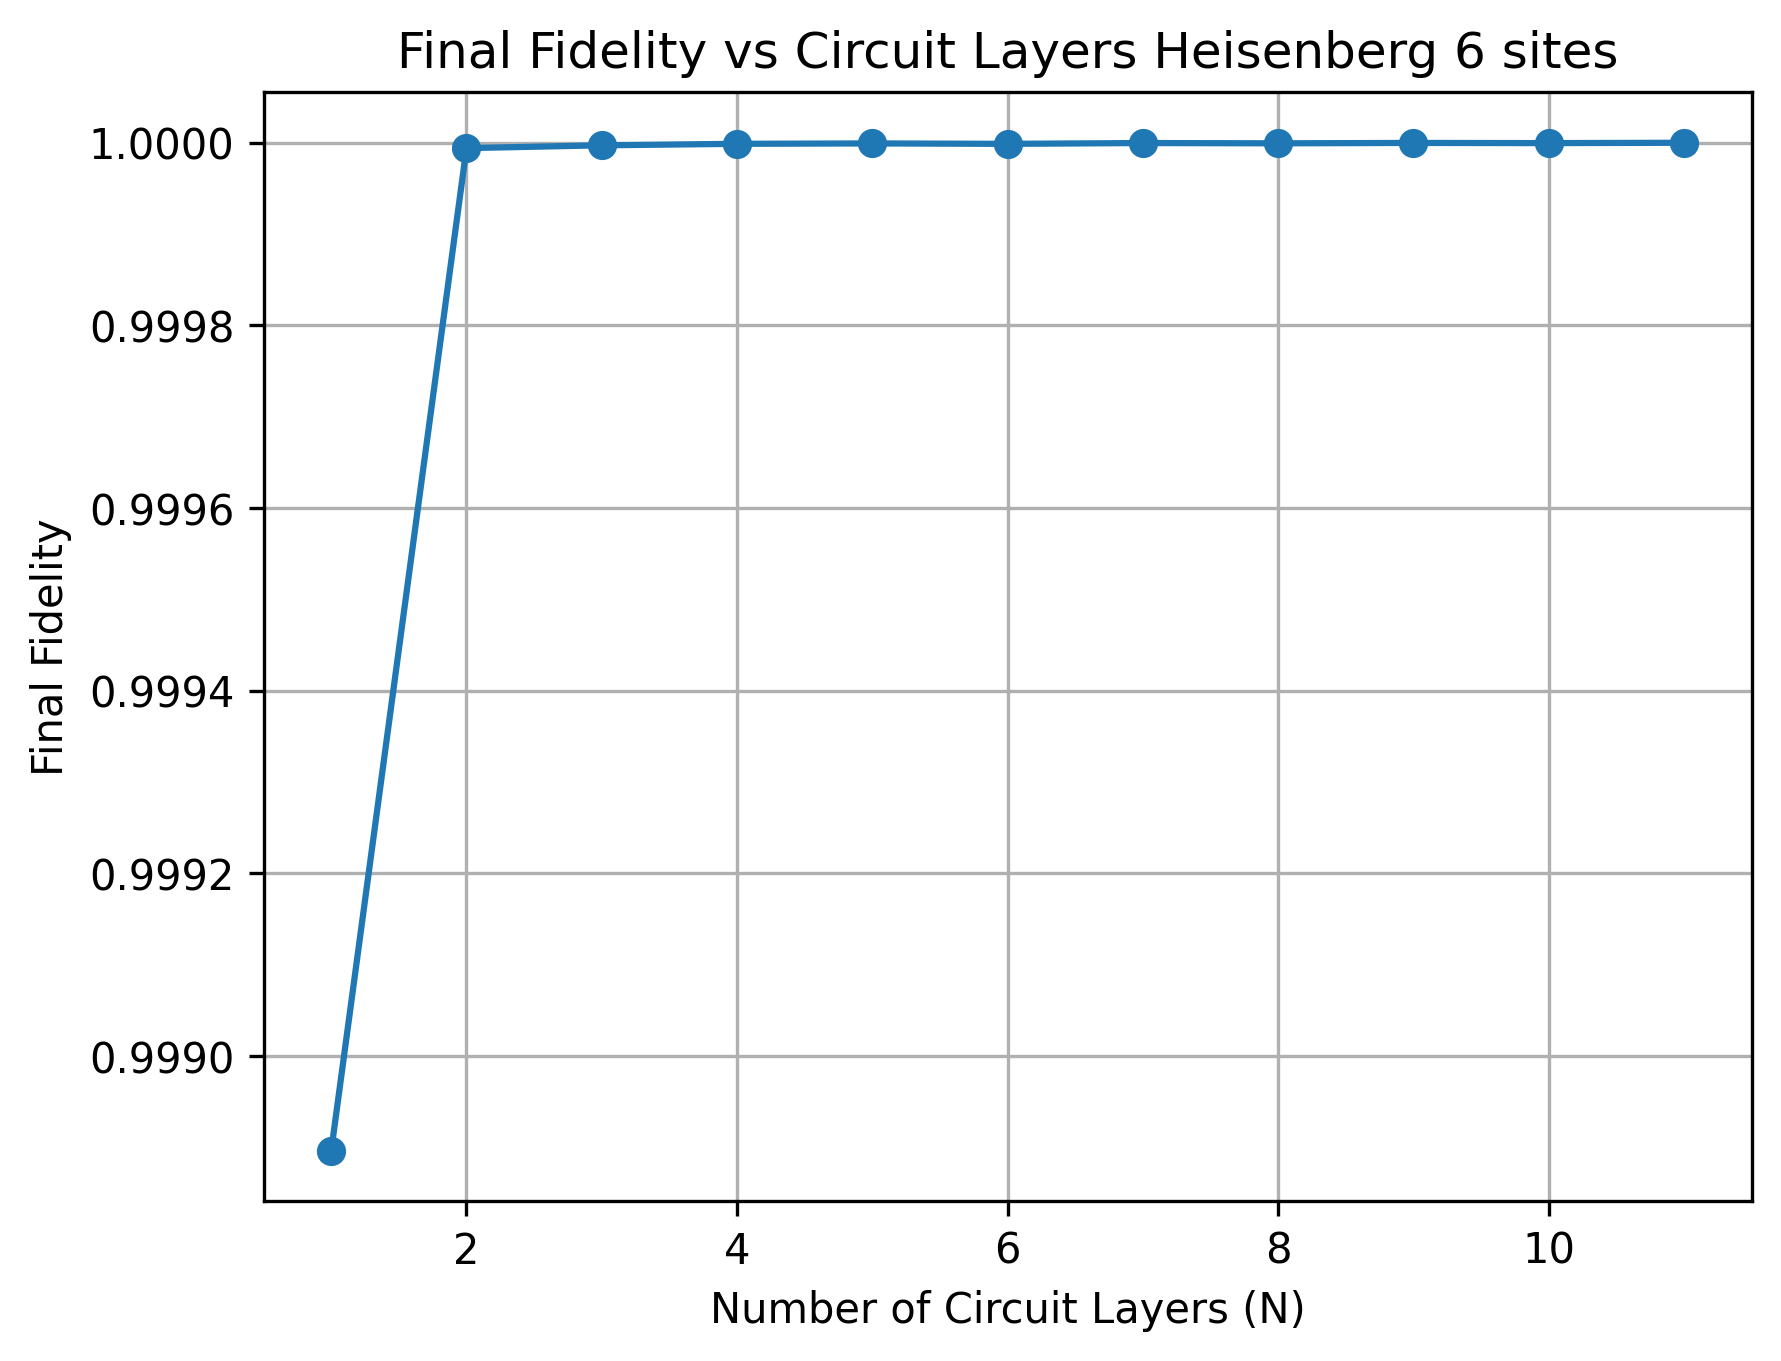

In [ ]:
import matplotlib.pyplot as plt
df_h = pd.read_csv(file_path_heisenberg)

# Plot MPO fidelity
plt.figure(dpi=300)
plt.plot(df_h['circuit_layers'], df_h['Final_fidelity'], marker='o')
plt.title('Final Fidelity vs Circuit Layers Heisenberg 6 sites')
plt.xlabel('Number of Circuit Layers (N)')
plt.ylabel('Final Fidelity')
plt.grid(True)
plt.show()

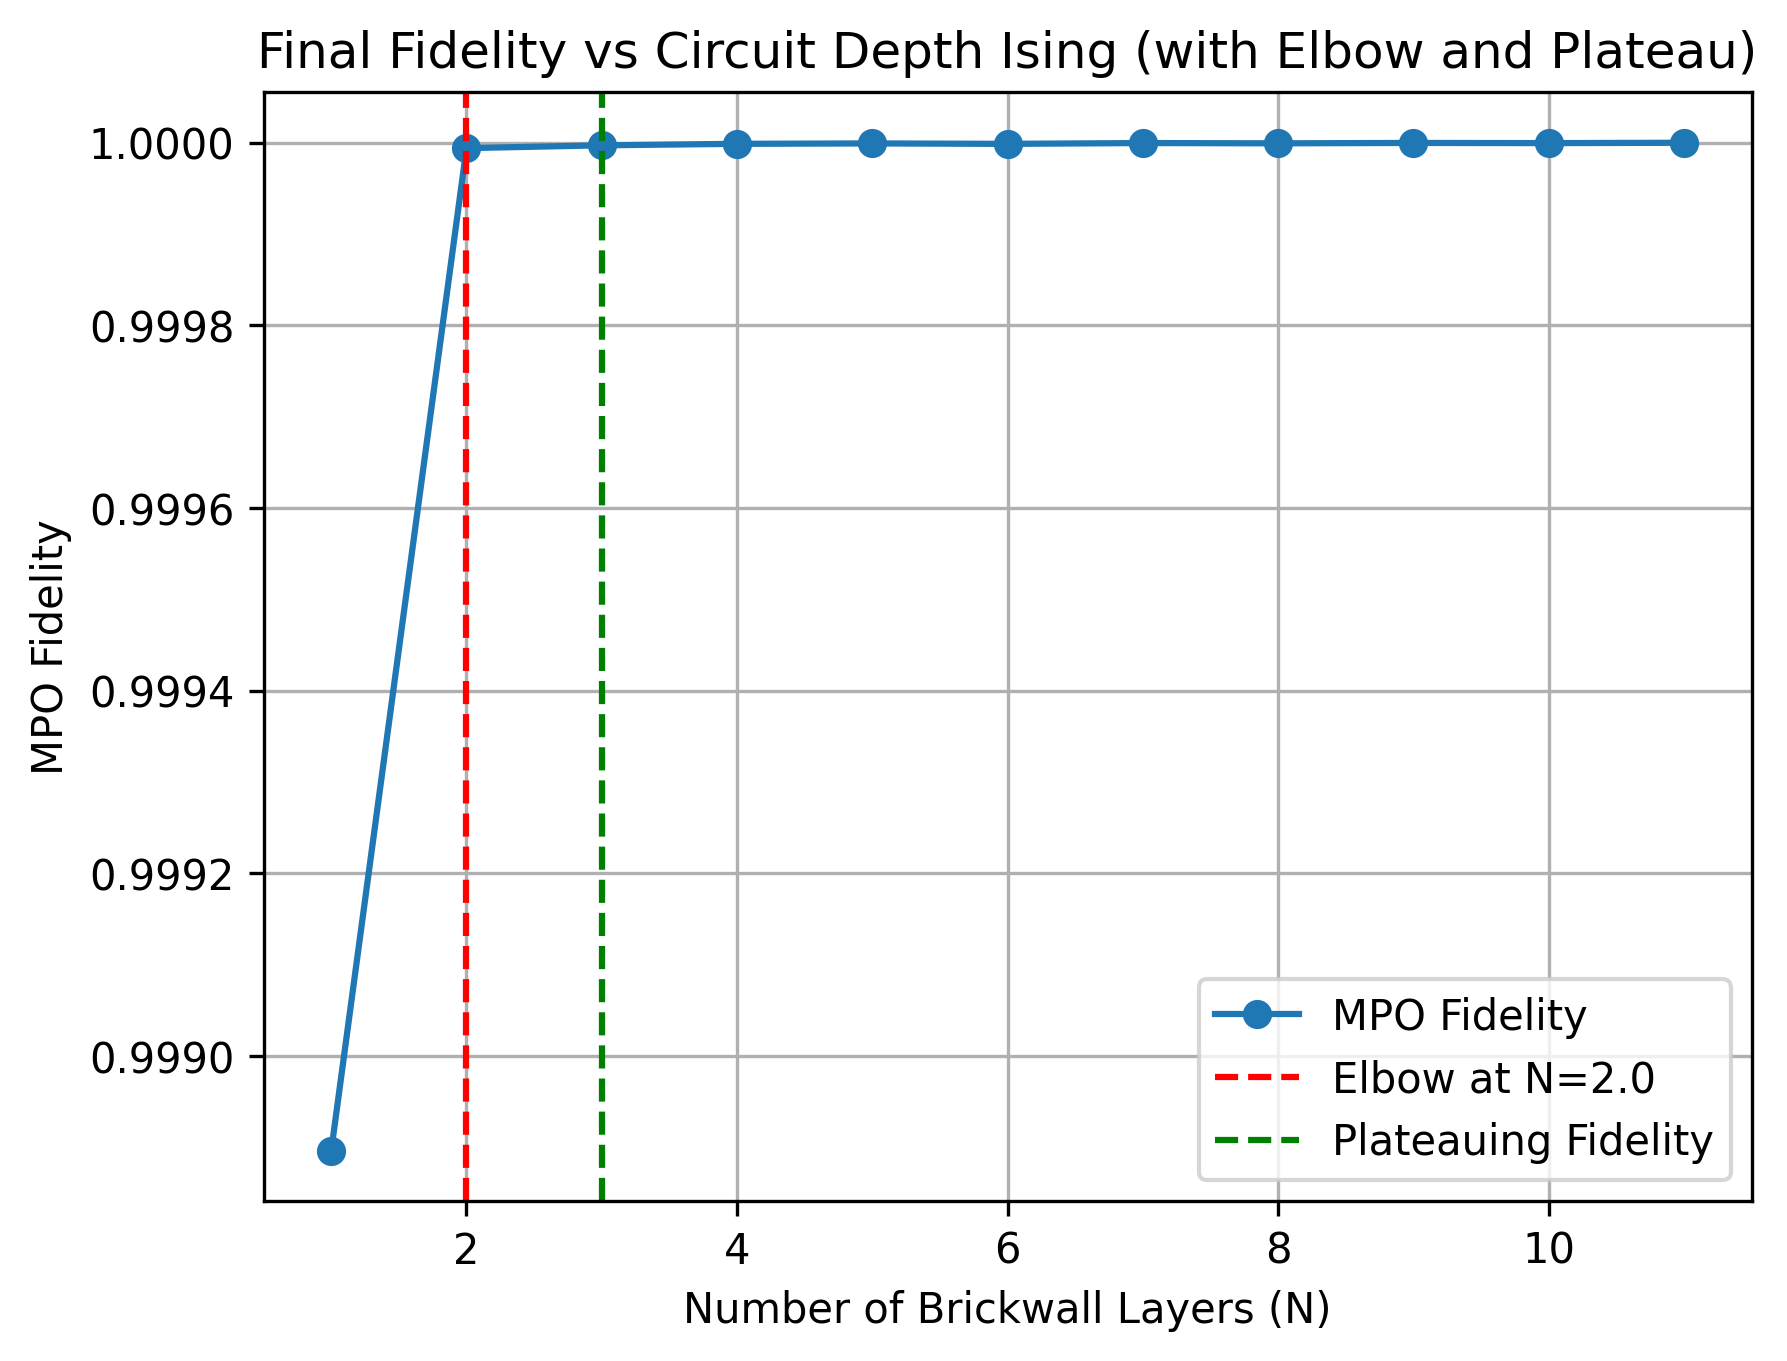


🔍 Suggested optimal compression depth: N = 3.0


In [ ]:
from ropt_aqc.brickwall_opt import plot_fidelity

elbow_N_h, plateau_N_h = plot_fidelity(df_h, 'Final_fidelity', n_repetitions, system)

In [ ]:
parameters_h = [float(param) for param in aqc_final_parameters_h]
print("Final parameters:", parameters)

In [ ]:
aqc_final_circuit_h = aqc_ansatz.assign_parameters(aqc_final_parameters_h)
aqc_final_circuit_h.draw("mpl", fold=-1)